<a href="https://colab.research.google.com/github/bukolastella/Data-Science/blob/master/Deep%20Learning/from%20directory/%20Latest%20commitCopy_of_Rock_Paper_Scissor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from tensorflow import keras
import tensorflow as tf
import os,datetime
import tensorflow_datasets as tfds

In [ ]:
tfds.list_builders() 

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'gr

In [ ]:
df, info = tfds.load('rock_paper_scissors', with_info = True, as_supervised = True)

In [ ]:
df

{'test': <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>,
 'train': <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>}

In [ ]:
info.splits["train"].num_examples

2520

In [ ]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [ ]:
class_names = info.features['label'].names

In [ ]:
num_validation = 0.1 * info.splits['train'].num_examples

In [ ]:
#A float
num_validation

252.0

In [ ]:
#Turning it to an integer as a float may cause problem along the way
num_validation = tf.cast(num_validation, tf.int64)

In [ ]:
train_data = df['train']
test_images = df['test']

In [ ]:
train_data

<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
#Since we are performing hold out validation we want to scale and shuffle at all times before taking out the validation set
def preprocess(image, labels):
  image = tf.cast(image, tf.float32)
  image /= 255.
  return image,labels

In [ ]:
valid_train_data = train_data.map(preprocess)
test_images = test_images.map(preprocess)

In [ ]:
valid_train_data

<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.float32, tf.int64)>

In [ ]:
#Shuffle the data 
valid_train_data_shuffled = valid_train_data.shuffle(1000)

In [ ]:
#Let's set out the validation data from the train data
valid_data = valid_train_data_shuffled.take(num_validation)
train_data = valid_train_data_shuffled.skip(num_validation)

In [ ]:
#Set no of bath size for test
num_test = info.splits['test'].num_examples
num_test = tf.cast(num_test, tf.int64)

In [ ]:
num_test

<tf.Tensor: shape=(), dtype=int64, numpy=372>

In [ ]:
batch_size = 32
train_data = train_data.batch(batch_size).prefetch(1)
valid_data = valid_data.batch(num_validation).prefetch(1)
test_images = test_images.batch(num_test).prefetch(1)

In [ ]:
train_images, train_labels = next(iter(train_data))
valid_images, valid_labels = next(iter(valid_data))
test_images, test_labels = next(iter(test_images))

In [ ]:
valid_images.shape

TensorShape([252, 300, 300, 3])

In [ ]:
train_images = tf.image.resize(train_images, (150, 150))
valid_images = tf.image.resize(valid_images, (150, 150))
test_images = tf.image.resize(test_images, (150, 150))

In [ ]:
train_images.shape

TensorShape([32, 150, 150, 3])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,  horizontal_flip=True)

it_gen = datagen.flow(train_images, train_labels, batch_size=32)

In [ ]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import numpy as np

In [ ]:
 model = Sequential([
                    Conv2D(32, 3, padding='same',  activation='relu',kernel_initializer='he_uniform', input_shape = [150, 150, 3]),
                    MaxPooling2D(2),
                    Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
                    MaxPooling2D(2),
                    Conv2D(64, 3, padding='same', kernel_initializer='he_uniform',activation='relu'),
                    MaxPooling2D(2),
                    Conv2D(64, 3, padding='same', kernel_initializer='he_uniform',activation='relu'),
                    MaxPooling2D(2),
                    Conv2D(128, 3, padding='same', kernel_initializer='he_uniform',activation='relu'),
                    MaxPooling2D(2),
                    Flatten(),
                    Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(3, activation = 'softmax'),
                    ])
steps = int(train_images.shape[0] / 32)
model.compile(optimizer= optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit( it_gen, epochs = 200, validation_data = (valid_images, valid_labels), 
                    callbacks = [early_stopping_cb], steps_per_epoch=steps, verbose=2)


Epoch 1/200
1/1 - 0s - loss: 1.6053 - accuracy: 0.3438 - val_loss: 2.9378 - val_accuracy: 0.2976
Epoch 2/200
1/1 - 0s - loss: 3.0415 - accuracy: 0.3438 - val_loss: 1.8038 - val_accuracy: 0.3889
Epoch 3/200
1/1 - 0s - loss: 2.0154 - accuracy: 0.3125 - val_loss: 1.2478 - val_accuracy: 0.3889
Epoch 4/200
1/1 - 0s - loss: 1.3614 - accuracy: 0.3125 - val_loss: 1.0433 - val_accuracy: 0.3929
Epoch 5/200
1/1 - 0s - loss: 1.0882 - accuracy: 0.3438 - val_loss: 1.1089 - val_accuracy: 0.3135
Epoch 6/200
1/1 - 0s - loss: 1.0935 - accuracy: 0.3438 - val_loss: 1.1548 - val_accuracy: 0.3214
Epoch 7/200
1/1 - 0s - loss: 1.1239 - accuracy: 0.3438 - val_loss: 1.1245 - val_accuracy: 0.3730
Epoch 8/200
1/1 - 0s - loss: 1.0733 - accuracy: 0.5312 - val_loss: 1.0798 - val_accuracy: 0.4563
Epoch 9/200
1/1 - 0s - loss: 1.0617 - accuracy: 0.5938 - val_loss: 1.0488 - val_accuracy: 0.5317
Epoch 10/200
1/1 - 0s - loss: 1.0460 - accuracy: 0.5312 - val_loss: 1.0381 - val_accuracy: 0.4603
Epoch 11/200
1/1 - 0s - loss:

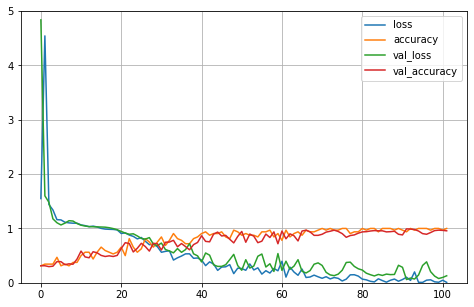

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,5) # set the vertical range to [0-1]

plt.show()

In [ ]:
#The first trial with conv 128 ended with a normal curve and accuracy of 53 but still under fitting
#The second with 256 ended with just a very small curvy straight line with accuracy of 48
#The third one with 512 follows the same thing with accuracy of 31
74

74

In [ ]:
model.summary()

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_646 (Conv2D)          (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_429 (MaxPoolin (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_647 (Conv2D)          (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_430 (MaxPoolin (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_648 (Conv2D)          (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_431 (MaxPoolin (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_649 (Conv2D)          (None, 18, 18, 64)     

In [ ]:
model.evaluate(test_images, test_labels)

12/12 [==============================] - 0s 8ms/step - loss: 0.1179 - accuracy: 0.9812


[0.11788799613714218, 0.9811828136444092]